In [1]:
# Dataset Loading and Analysis for Drywall QA Prompted Segmentation

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from load import get_dataset_files
import torch.nn.functional as F
from dataset import create_combined_dataset, DryWallQADataset
from visualize import visualize_samples, detailed_sample_analysis, get_sample_indices, visualize_preds_and_masks
from train import setup_model, setup_data_loaders, collate_fn, configure_trainable_parameters, get_training_config, train_one_epoch, evaluate
from metrics import calculate_iou, calculate_dice, calculate_pixel_accuracy, evaluate_model_with_metrics, visualize_predictions_with_metrics
from process import process_predicted_mask

# Set up paths
BASE_DIR = Path("/Users/prashanthreddyduggirala/10x")
CRACKS_DATASET = BASE_DIR / "cracks.v1i.voc"
DRYWALL_DATASET = BASE_DIR / "Drywall-Join-Detect.v1i.voc"

print("Imports successful!")

DryWallQADataset class defined!
create_combined_dataset function defined!

Dataset features:
- Handles both polygon (crack) and bounding box (drywall) annotations
- Multiple text prompts per category for data augmentation
- Creates binary masks for CLIPSeg training


/Users/prashanthreddyduggirala/10x/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful!


In [2]:
# Load both datasets
print("Loading crack detection dataset...")
cracks_files = get_dataset_files(CRACKS_DATASET)

print("Loading drywall joint detection dataset...")
drywall_files = get_dataset_files(DRYWALL_DATASET)

Loading crack detection dataset...
Loading drywall joint detection dataset...


In [3]:
# Create the combined dataset
print("Creating combined dataset...")
train_images, train_annotations, train_prompts, train_labels = create_combined_dataset(['train'], cracks_files, drywall_files)
val_images, val_annotations, val_prompts, val_labels = create_combined_dataset(['valid'], cracks_files, drywall_files)

print(f"Combined datasets created!")
print(f"   Total train samples: {len(train_images)}")
print(f"   Total validation samples: {len(val_images)}")


train_crack_count = train_labels.count('crack')
train_drywall_count = train_labels.count('drywall_joint')
val_crack_count = val_labels.count('crack')
val_drywall_count = val_labels.count('drywall_joint')


# Create dataset instance
train_dataset = DryWallQADataset(train_images, train_annotations, train_prompts)
print(f"\nTrain Dataset instance created with {len(train_dataset)} samples")

val_dataset = DryWallQADataset(val_images, val_annotations, val_prompts)
print(f"Validation Dataset instance created with {len(val_dataset)} samples")


Creating combined dataset...
Combined datasets created!
   Total train samples: 5984
   Total validation samples: 403

Train Dataset instance created with 5984 samples
Validation Dataset instance created with 403 samples


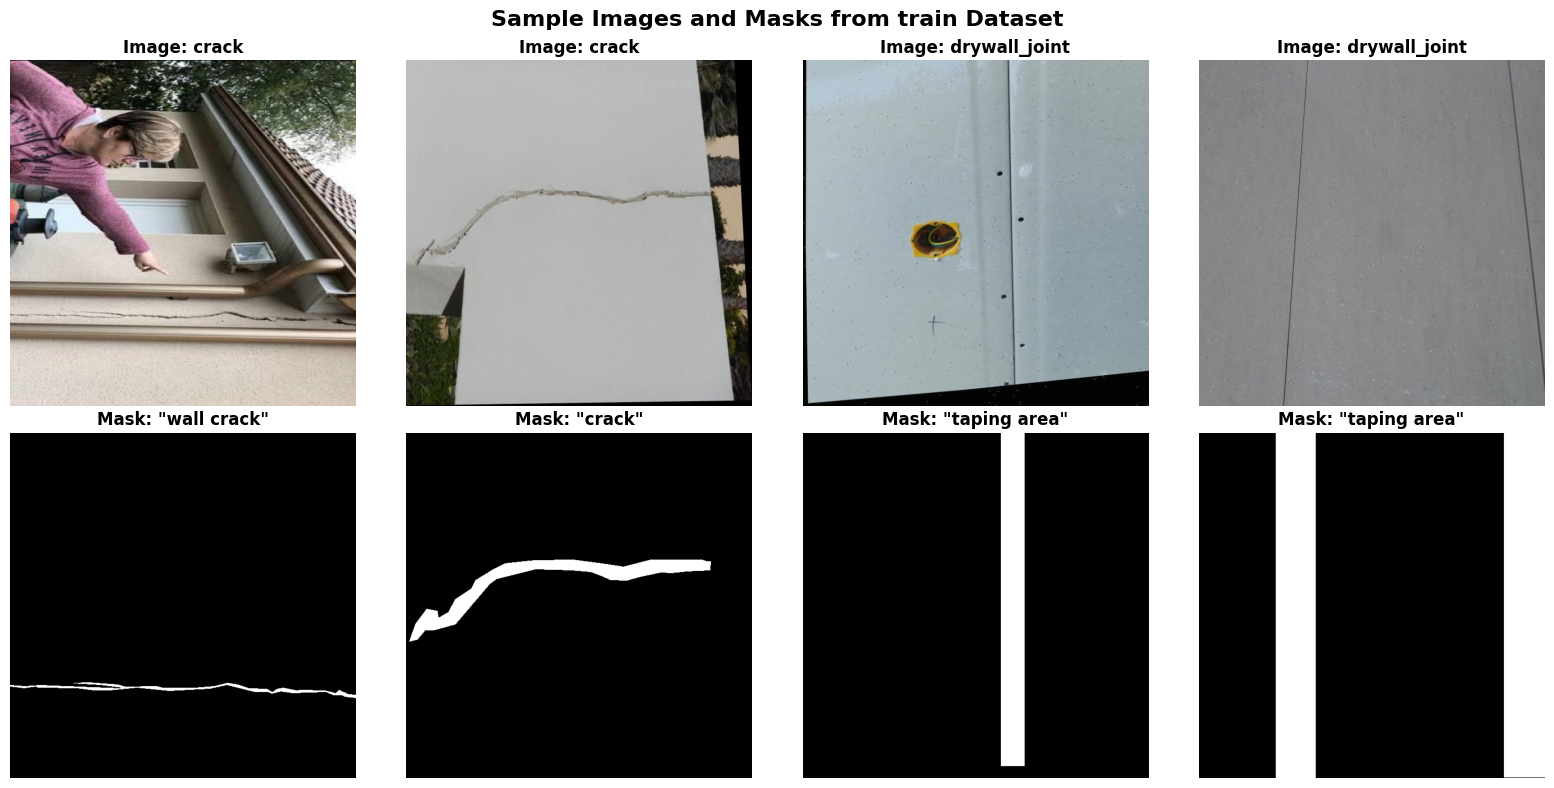

🔍 DETAILED SAMPLE ANALYSIS:

Sample 1 (crack):
  Text prompt: 'wall crack'
  Mask coverage: 0.81% of image
  Mask pixels: 3,316 / 409,600
  Filename: cracking0153_jpg.rf.d6b2c089a3280d0cd62a67a27dd18ba6.jpg

Sample 2 (crack):
  Text prompt: 'crack'
  Mask coverage: 3.44% of image
  Mask pixels: 14,097 / 409,600
  Filename: crack277_jpg.rf.15e994d62ce8bdf48d816c1fe9016975.jpg

Sample 3 (drywall_joint):
  Text prompt: 'taping area'
  Mask coverage: 6.63% of image
  Mask pixels: 27,148 / 409,600
  Filename: IMG_20220627_111635-jpg_1500x2000_jpg.rf.47e5091ac61f1763481557f905115371.jpg

Sample 4 (drywall_joint):
  Text prompt: 'taping area'
  Mask coverage: 23.38% of image
  Mask pixels: 95,774 / 409,600
  Filename: 2000x1500_68_resized_jpg.rf.2d4a90cbfd15f0642aecf368019cffa1.jpg


In [4]:
sample_indices = get_sample_indices(train_labels)
visualize_samples(train_dataset, train_labels, sample_indices)
detailed_sample_analysis(train_dataset, train_labels, sample_indices)

In [8]:
model, processor, device = setup_model(checkpoint_path="/Users/prashanthreddyduggirala/10x/checkpoints/best_clipseg_drywall_model_v3.pth")

SETTING UP CLIPSEG MODEL
Loading checkpoint from: /Users/prashanthreddyduggirala/10x/checkpoints/best_clipseg_drywall_model_v3.pth
Checkpoint loaded successfully!
   Epoch: 7
   Validation Loss: 0.1347
   Training Loss: 0.0872
Model loaded and moved to: cpu


In [7]:
encoder_params_list, decoder_params_list = configure_trainable_parameters(model)

CONFIGURING TRAINABLE PARAMETERS
Trainable parameters: 150,747,746 / 150,747,746 (100.0%)


In [7]:
config = get_training_config(
    batch_size=16,
    encoder_lr=1e-6,
    decoder_lr=1e-4,
    num_epochs=10,
    save_every=None,
    eval_every=170,
    optim_weight_decay=1e-5,
    checkpoint_base_path="/Users/prashanthreddyduggirala/10x/checkpoints/"
)

🔧 TRAINING CONFIGURATION
Batch size: 16
Learning rate: 1e-06
Number of epochs: 10
Save frequency: Only best model at epoch end
Eval frequency: Every 170 steps
Eval configuration: 170


In [8]:
train_loader, val_loader = setup_data_loaders(train_dataset, val_dataset, processor, config)

SETTING UP DATA LOADERS
Batch size: 16
Data loaders created:
   Train batches: 374
   Validation batches: 26
   Samples per epoch: 5984


In [ ]:
import time
from torch.nn import BCEWithLogitsLoss

# Fixed Main Training Loop
print("STARTING CLIPSEG TRAINING")
print("=" * 50)

optimizer = torch.optim.AdamW([
    # Now this list comprehension works because we use the *list* version
    {'params': encoder_params_list, 'lr': config['encoder_lr']},
    {'params': decoder_params_list, 'lr': config['decoder_lr']}
],
# Apply global weight decay
weight_decay=config.get('optim_weight_decay')
)
criterion = BCEWithLogitsLoss()

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"Training Details:")
print(f"   Optimizer: AdamW (encoder lr={config['encoder_lr']}, decoder lr={config['decoder_lr']})")
print(f"   Loss function: BCEWithLogitsLoss")
print(f"   Device: {device}")
print(f"   Model input: 640x640 -> 352x352 (internal)")
print(f"   Model output: 352x352 -> 640x640 (upsampled)")

# Start training
start_time = time.time()

for epoch in range(config['num_epochs']):
    print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
    print("-" * 30)
    
    # Train for one epoch
    epoch_start = time.time()
    train_loss = train_one_epoch(
        model, 
        train_loader, 
        optimizer, 
        criterion, 
        device, 
        epoch, 
        save_every=config.get('save_every'),
        eval_every=config.get('eval_every'),
        val_loader=val_loader,
        checkpoint_path_prefix=config.get('checkpoint_base_path') + "clipseg_drywall_model", 
    )
    
    # Evaluate on validation set
    val_loss = evaluate(model, val_loader, criterion, device)
    
    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print epoch results
    print(f"Epoch {epoch+1} completed in {epoch_time:.1f}s")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"New best validation loss: {val_loss:.4f}")
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, config['checkpoint_base_path'] + 'clipseg_drywall_model' + f"_{epoch}.pth")
        print(f"Model saved as 'clipseg_drywall_model_{epoch}.pth'")

In [9]:
test_images, test_annotations, test_prompts, test_labels = create_combined_dataset(['test'], cracks_files, drywall_files)
test_dataset = DryWallQADataset(test_images, test_annotations, test_prompts)
print(f"Test Dataset instance created with {len(test_dataset)} samples")

Test Dataset instance created with 4 samples


/Users/prashanthreddyduggirala/10x/.venv/lib/python3.11/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


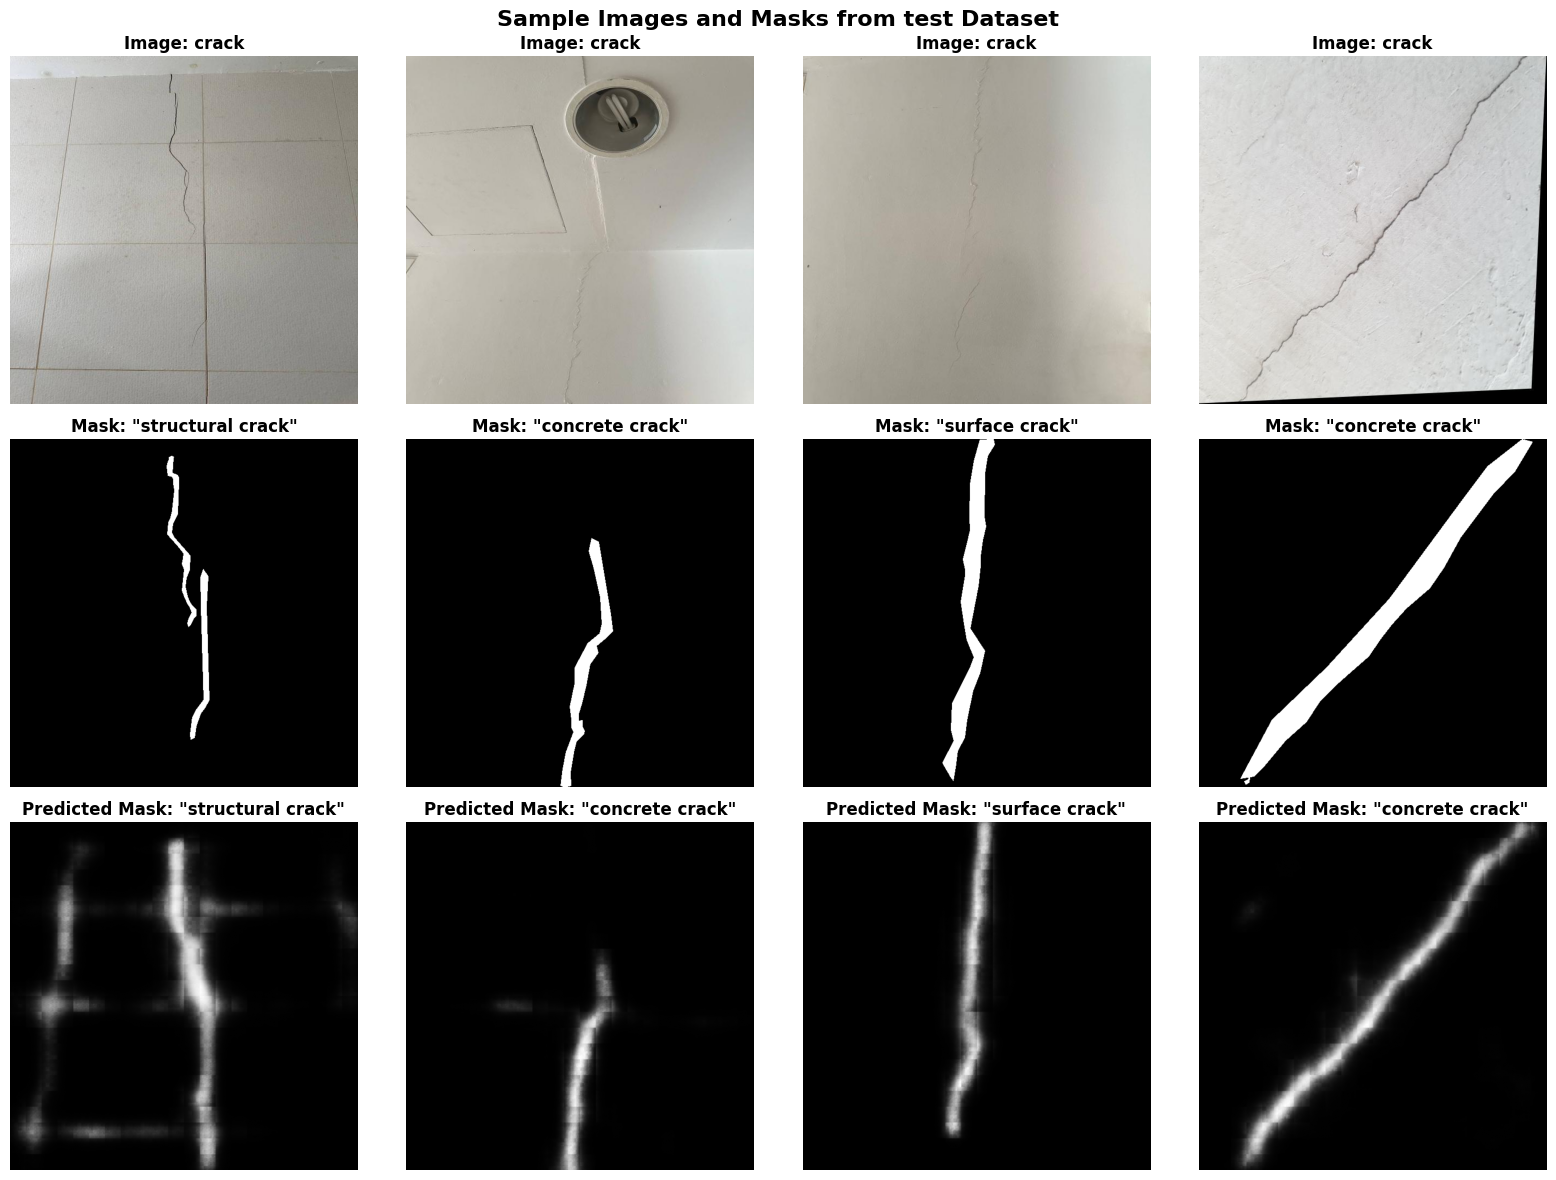

In [10]:
visualize_preds_and_masks(model, processor, test_dataset, test_labels, device, random_seed=102)

RUNNING COMPREHENSIVE EVALUATION
Running evaluation on validation set...
🔍 Evaluating model performance...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluation: 100%|██████████| 26/26 [01:03<00:00,  2.45s/it]


EVALUATION RESULTS

Overall (403 samples):
   mIoU:        0.5271 ± 0.1769
   mDice:       0.6707 ± 0.1721
   Pixel Acc:   0.9375 ± 0.0604

Cracks (201 samples):
   mIoU:        0.4937 ± 0.1910
   mDice:       0.6375 ± 0.1865
   Pixel Acc:   0.9596 ± 0.0332

Drywall Joints (202 samples):
   mIoU:        0.5604 ± 0.1546
   mDice:       0.7037 ± 0.1492
   Pixel Acc:   0.9155 ± 0.0722


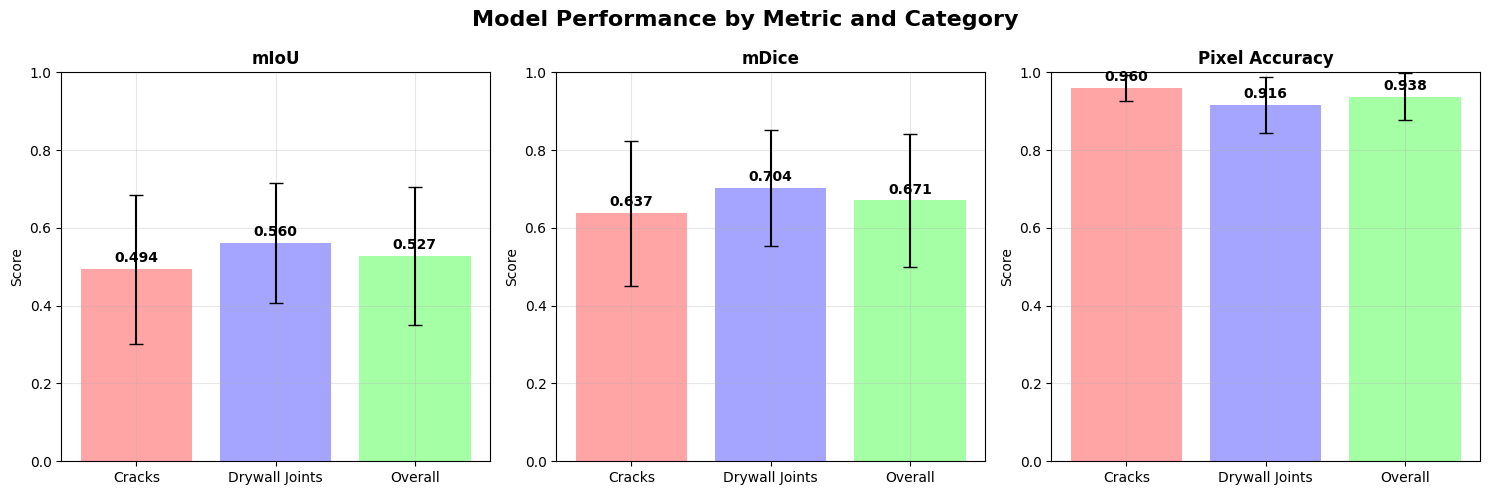


PERFORMANCE SUMMARY
Best performing category by mIoU: Drywall Joints (0.5604)
Overall model performance:
   - mIoU: 0.5271 (Higher is better)
   - mDice: 0.6707 (Higher is better)
   - Pixel Acc: 0.9375 (Higher is better)
Good segmentation performance (mIoU > 0.5)


In [11]:
# Run Comprehensive Evaluation
print("RUNNING COMPREHENSIVE EVALUATION")
print("=" * 50)

# Run evaluation on a subset first (faster for testing)
print("Running evaluation on validation set...")
results, detailed_metrics = evaluate_model_with_metrics(
    model=model, 
    val_loader=val_loader, 
    val_labels=val_labels, 
    device=device,
    num_samples=None  # Set to None to evaluate all samples, or a number like 100 for subset
)

# Display results
print("\nEVALUATION RESULTS")
print("=" * 50)

categories = ['overall', 'crack', 'drywall_joint']
category_names = ['Overall', 'Cracks', 'Drywall Joints']

for cat, name in zip(categories, category_names):
    if results[cat]['sample_count'] > 0:
        print(f"\n{name} ({results[cat]['sample_count']} samples):")
        print(f"   mIoU:        {results[cat]['mIoU']:.4f} ± {results[cat]['mIoU_std']:.4f}")
        print(f"   mDice:       {results[cat]['mDice']:.4f} ± {results[cat]['mDice_std']:.4f}")
        print(f"   Pixel Acc:   {results[cat]['mPixel_Acc']:.4f} ± {results[cat]['mPixel_Acc_std']:.4f}")
    else:
        print(f"\n{name}: No samples found")

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance by Metric and Category', fontsize=16, fontweight='bold')

metrics_to_plot = ['mIoU', 'mDice', 'mPixel_Acc']
metric_labels = ['mIoU', 'mDice', 'Pixel Accuracy']

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    # Extract values for each category
    crack_val = results['crack'][metric] if results['crack']['sample_count'] > 0 else 0
    drywall_val = results['drywall_joint'][metric] if results['drywall_joint']['sample_count'] > 0 else 0
    overall_val = results['overall'][metric]
    
    crack_std = results['crack'][f'{metric}_std'] if results['crack']['sample_count'] > 0 else 0
    drywall_std = results['drywall_joint'][f'{metric}_std'] if results['drywall_joint']['sample_count'] > 0 else 0
    overall_std = results['overall'][f'{metric}_std']
    
    # Create bar plot
    categories = ['Cracks', 'Drywall Joints', 'Overall']
    values = [crack_val, drywall_val, overall_val]
    errors = [crack_std, drywall_std, overall_std]
    
    bars = axes[i].bar(categories, values, yerr=errors, capsize=5, 
                       color=['#ff7f7f', '#7f7fff', '#7fff7f'], alpha=0.7)
    
    axes[i].set_title(f'{label}', fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].set_ylim(0, 1.0)
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Performance summary
print(f"\nPERFORMANCE SUMMARY")
print("=" * 30)
print(f"Best performing category by mIoU: ", end="")
if results['crack']['sample_count'] > 0 and results['drywall_joint']['sample_count'] > 0:
    if results['crack']['mIoU'] > results['drywall_joint']['mIoU']:
        print(f"Cracks ({results['crack']['mIoU']:.4f})")
    else:
        print(f"Drywall Joints ({results['drywall_joint']['mIoU']:.4f})")
else:
    print("Cannot compare - insufficient samples")

print(f"Overall model performance:")
print(f"   - mIoU: {results['overall']['mIoU']:.4f} (Higher is better)")
print(f"   - mDice: {results['overall']['mDice']:.4f} (Higher is better)")
print(f"   - Pixel Acc: {results['overall']['mPixel_Acc']:.4f} (Higher is better)")

if results['overall']['mIoU'] > 0.5:
    print("Good segmentation performance (mIoU > 0.5)")
elif results['overall']['mIoU'] > 0.3:
    print("Moderate segmentation performance (mIoU > 0.3)")
else:
    print("Poor segmentation performance (mIoU < 0.3)")

Visualizing sample predictions with metrics...


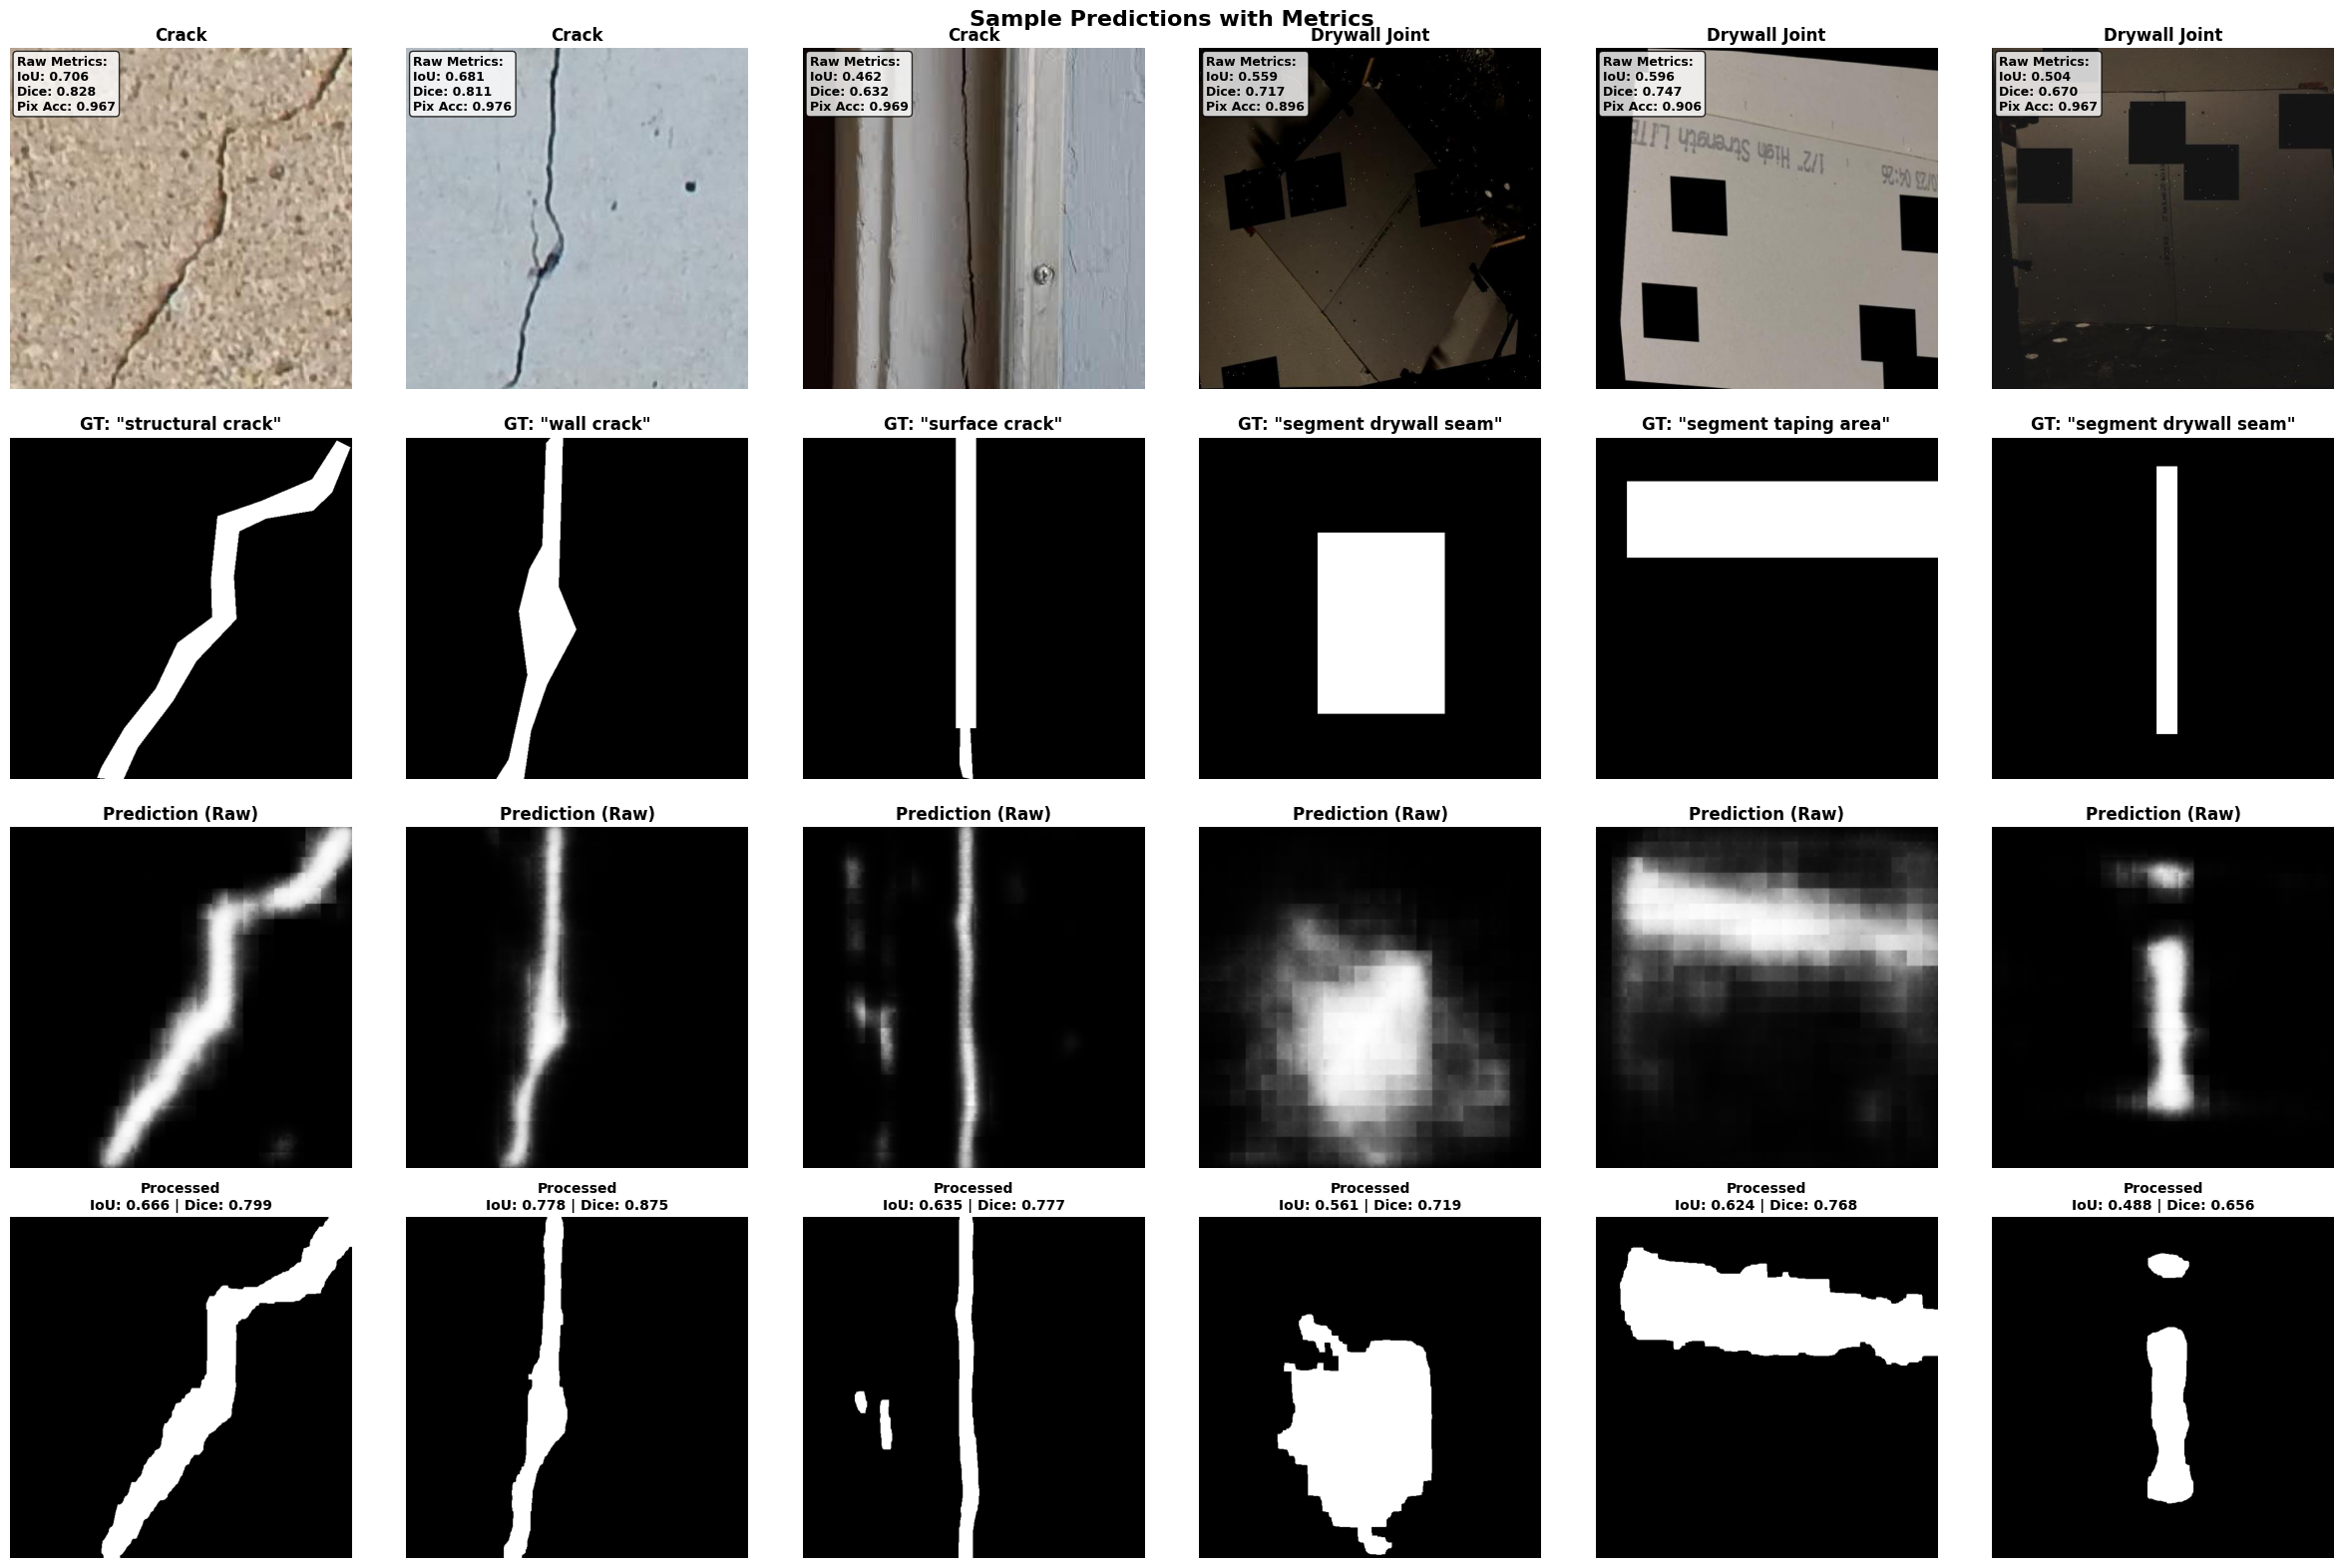

In [10]:
print("Visualizing sample predictions with metrics...")
sample_indices = visualize_predictions_with_metrics(model, processor, val_dataset, val_labels, device, num_samples=6)

In [11]:
print(f"\nDETAILED METRICS FOR DISPLAYED SAMPLES:")
print("=" * 50)

for i, sample_idx in enumerate(sample_indices):
    sample = val_dataset[sample_idx]
    label_type = val_labels[sample_idx]
    
    # Get prediction for this sample
    debug_batch = collate_fn([sample], processor)
    with torch.no_grad():
        outputs = model(
            input_ids=debug_batch['input_ids'].to(device),
            attention_mask=debug_batch['attention_mask'].to(device),
            pixel_values=debug_batch['pixel_values'].to(device)
        )
    
    logits = outputs.logits
    if len(logits.shape) == 3:
        logits = logits.unsqueeze(1)
    
    preds = F.interpolate(logits, size=(640, 640), mode='bilinear', align_corners=False)
    preds = preds.squeeze(1).squeeze(0)
    preds = torch.sigmoid(preds)
    
    # Calculate all metrics
    true_mask = np.array(sample['mask']) / 255.0
    pred_mask = preds.cpu().numpy()
    processed_mask = process_predicted_mask(pred_mask) / 255.0
    
    raw_iou = calculate_iou(pred_mask, true_mask)
    raw_dice = calculate_dice(pred_mask, true_mask)
    raw_acc = calculate_pixel_accuracy(pred_mask, true_mask)
    
    proc_iou = calculate_iou(processed_mask, true_mask)
    proc_dice = calculate_dice(processed_mask, true_mask)
    proc_acc = calculate_pixel_accuracy(processed_mask, true_mask)
    
    print(f"\nSample {i+1} ({label_type} - '{sample['text_prompt']}'):")
    print(f"   Raw Prediction:       IoU={raw_iou:.4f}, Dice={raw_dice:.4f}, Acc={raw_acc:.4f}")
    print(f"   Processed Prediction: IoU={proc_iou:.4f}, Dice={proc_dice:.4f}, Acc={proc_acc:.4f}")
    
    improvement = proc_iou - raw_iou
    if improvement > 0.01:
        print(f"   Processing improved IoU by {improvement:.4f}")
    elif improvement < -0.01:
        print(f"   Processing reduced IoU by {abs(improvement):.4f}")
    else:
        print(f"   Processing had minimal effect on IoU")


DETAILED METRICS FOR DISPLAYED SAMPLES:

Sample 1 (crack - 'structural crack'):
   Raw Prediction:       IoU=0.7061, Dice=0.8277, Acc=0.9666
   Processed Prediction: IoU=0.6658, Dice=0.7993, Acc=0.9582
   Processing reduced IoU by 0.0403

Sample 2 (crack - 'wall crack'):
   Raw Prediction:       IoU=0.6814, Dice=0.8105, Acc=0.9755
   Processed Prediction: IoU=0.7781, Dice=0.8752, Acc=0.9824
   Processing improved IoU by 0.0967

Sample 3 (crack - 'surface crack'):
   Raw Prediction:       IoU=0.4617, Dice=0.6317, Acc=0.9694
   Processed Prediction: IoU=0.6349, Dice=0.7767, Acc=0.9767
   Processing improved IoU by 0.1733

Sample 4 (drywall_joint - 'segment drywall seam'):
   Raw Prediction:       IoU=0.5586, Dice=0.7168, Acc=0.8962
   Processed Prediction: IoU=0.5610, Dice=0.7188, Acc=0.8890
   Processing had minimal effect on IoU

Sample 5 (drywall_joint - 'segment taping area'):
   Raw Prediction:       IoU=0.5961, Dice=0.7470, Acc=0.9060
   Processed Prediction: IoU=0.6240, Dice=0.76